# Example 3: Uploading CT images as numpy file extension and data processing workflow.
This example contains a detailed explanation how to read numpy file extension (.npy). Furthermore, an explanation of the proposed workflow to preprocess CT images and postprocess to obtain $CO_2$ saturation.

In [1]:
# Import functions libraries
import readers_preprocessing as rp
import plot_scans as ps
import co2_postprocessing as cp

To save time it is recommend to save your scans from dicom files to numpy extension (.npy). The function below loads CT scans numpy arrays using `read_slices_from_numpy` function available at **readers_preprocessing** file

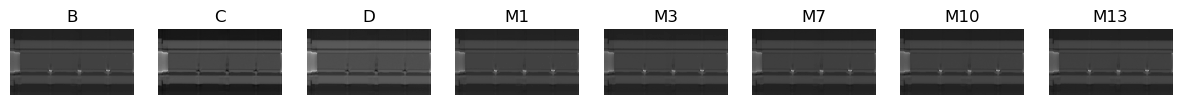

In [2]:
# Load numpy arrays from folder
files = ['B','C','D','M1','M3','M7','M10','M13']
path = 'C:/Users/josee/Box/2022-2023 GRA/ct_numpy/'

idict = rp.read_slices_from_numpy(path,files)

# Plot scans
ps.compare_scans(idict)

The workflow proposed in previous examples, starts with centering the CT scans to the midpoint of the image grid (slice) depending on your slice size (NxN). Centering function `center_itk` uses the bottom and top center of the core to align the slices. **Please refer to ImageJ center tutorial** for an explanation how to extract the centroid of the core.

In [3]:
# Center scans 
cdict = {}
xi = 4*69 ; yi = 4*71.5 ; xf = 4*67.5 ; yf = 4*71.75

for key in idict.keys():
    cdict[key] = rp.center_itk(idict[key],xi,yi,xf,yf)

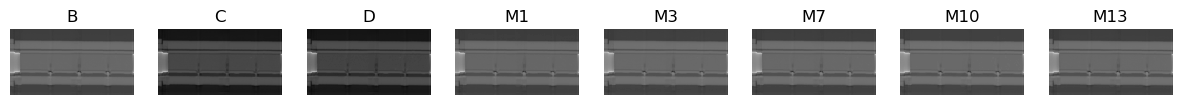

In [4]:
# Compare scans after centering
ps.compare_scans(cdict)

After centering the scans, it is necessary to crop the image to the volume of interest (core). Top and bottom slice number can be obtained from ImageJ. Function `mask_images` crops the volume of the core given the core radius (px), bottom and top slices.

In [5]:
# Mask images
i = 105 ; f = 1034
mdict = {}
for key in cdict.keys():
    mdict[key] = rp.mask_images(cdict[key],65,i,f)

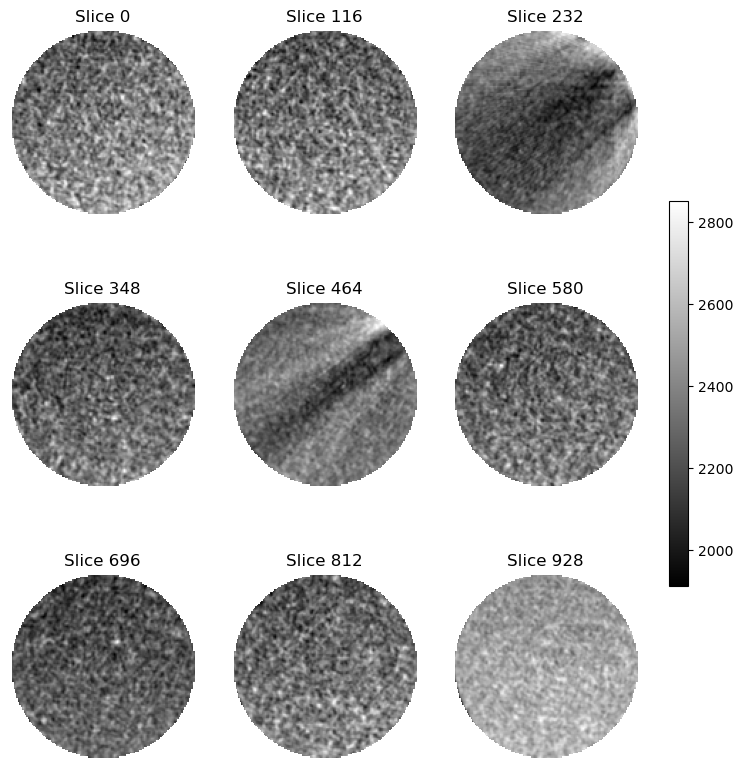

In [6]:
# Plot slices 
ps.plot_slices(mdict['B'],3,3)

It is important to plot the distribution of the CT number, to quantify the uncertainty during the scanning procedure and to help select the best smoothing parameters.

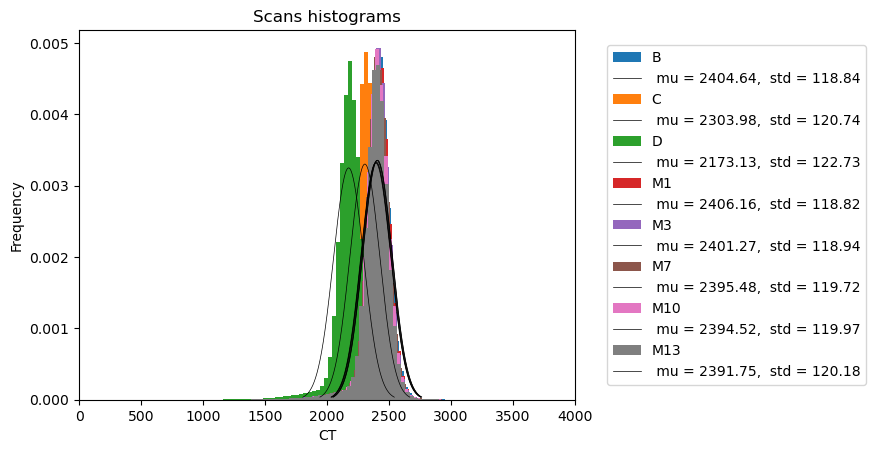

In [7]:
# Compare histograms
ps.plot_multiple_histograms(mdict)

After cropping the volume of interest, a denoising scheme should be applied. In this tutorial, we decided to apply gaussian filter, followed by a median filter and voxel coarsening scheme

In [8]:
# Apply gaussian filter
gdict = {}
for key in mdict.keys():
    gdict[key] = rp.apply_gaussian(mdict[key],sigma=1)

In [9]:
# Resample scans
fdict = {}
for key in gdict.keys():
    fdict[key] = rp.resample(mdict[key],size=5,resolution=[0.25,0.25,0.25],new_spacing=[2,2,2])

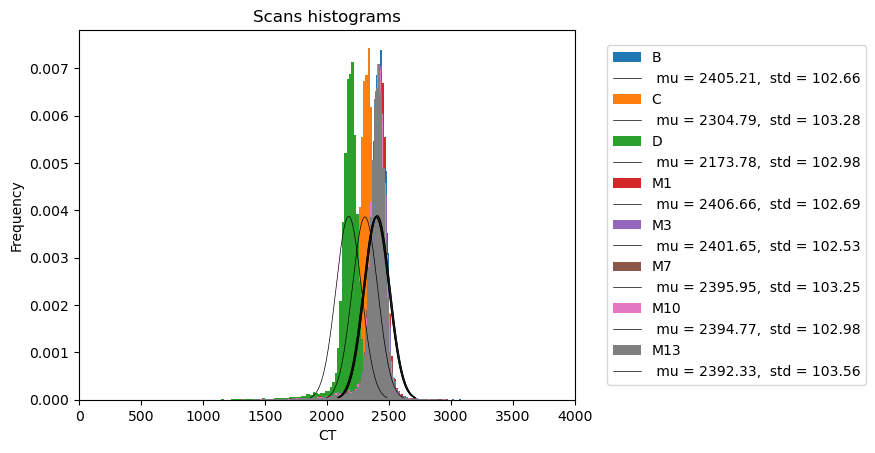

In [10]:
ps.plot_multiple_histograms(fdict)

Finally, after preprocessing the CT images. Functions to estimate porosity and drainage saturation are available in co2_postprocessing function file.

Core level porosity estimate: 0.231


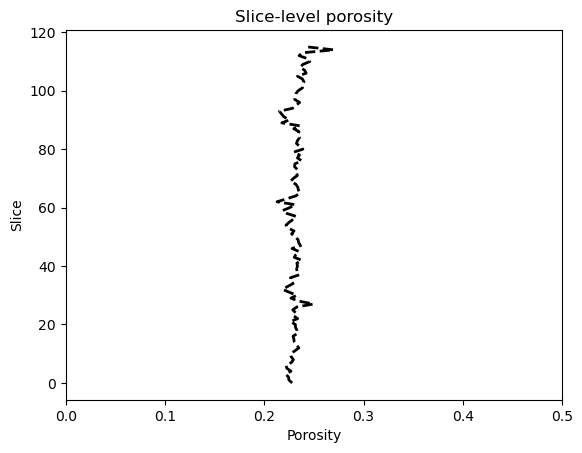

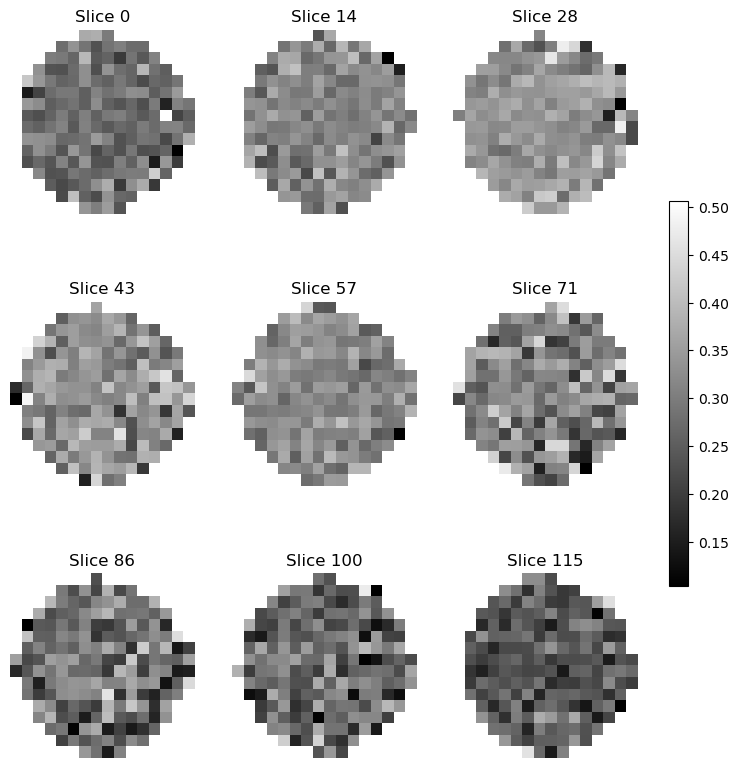

In [11]:
# Estimate porosity
wet = fdict['B'] ; dry = fdict['D']
# Core level
core_por = cp.core_level_porosity(dry,wet)
# Slice level
slice_por = cp.slice_level_porosity(dry,wet)
# Voxel level
voxel_por = cp.voxel_level_porosity(dry,wet)

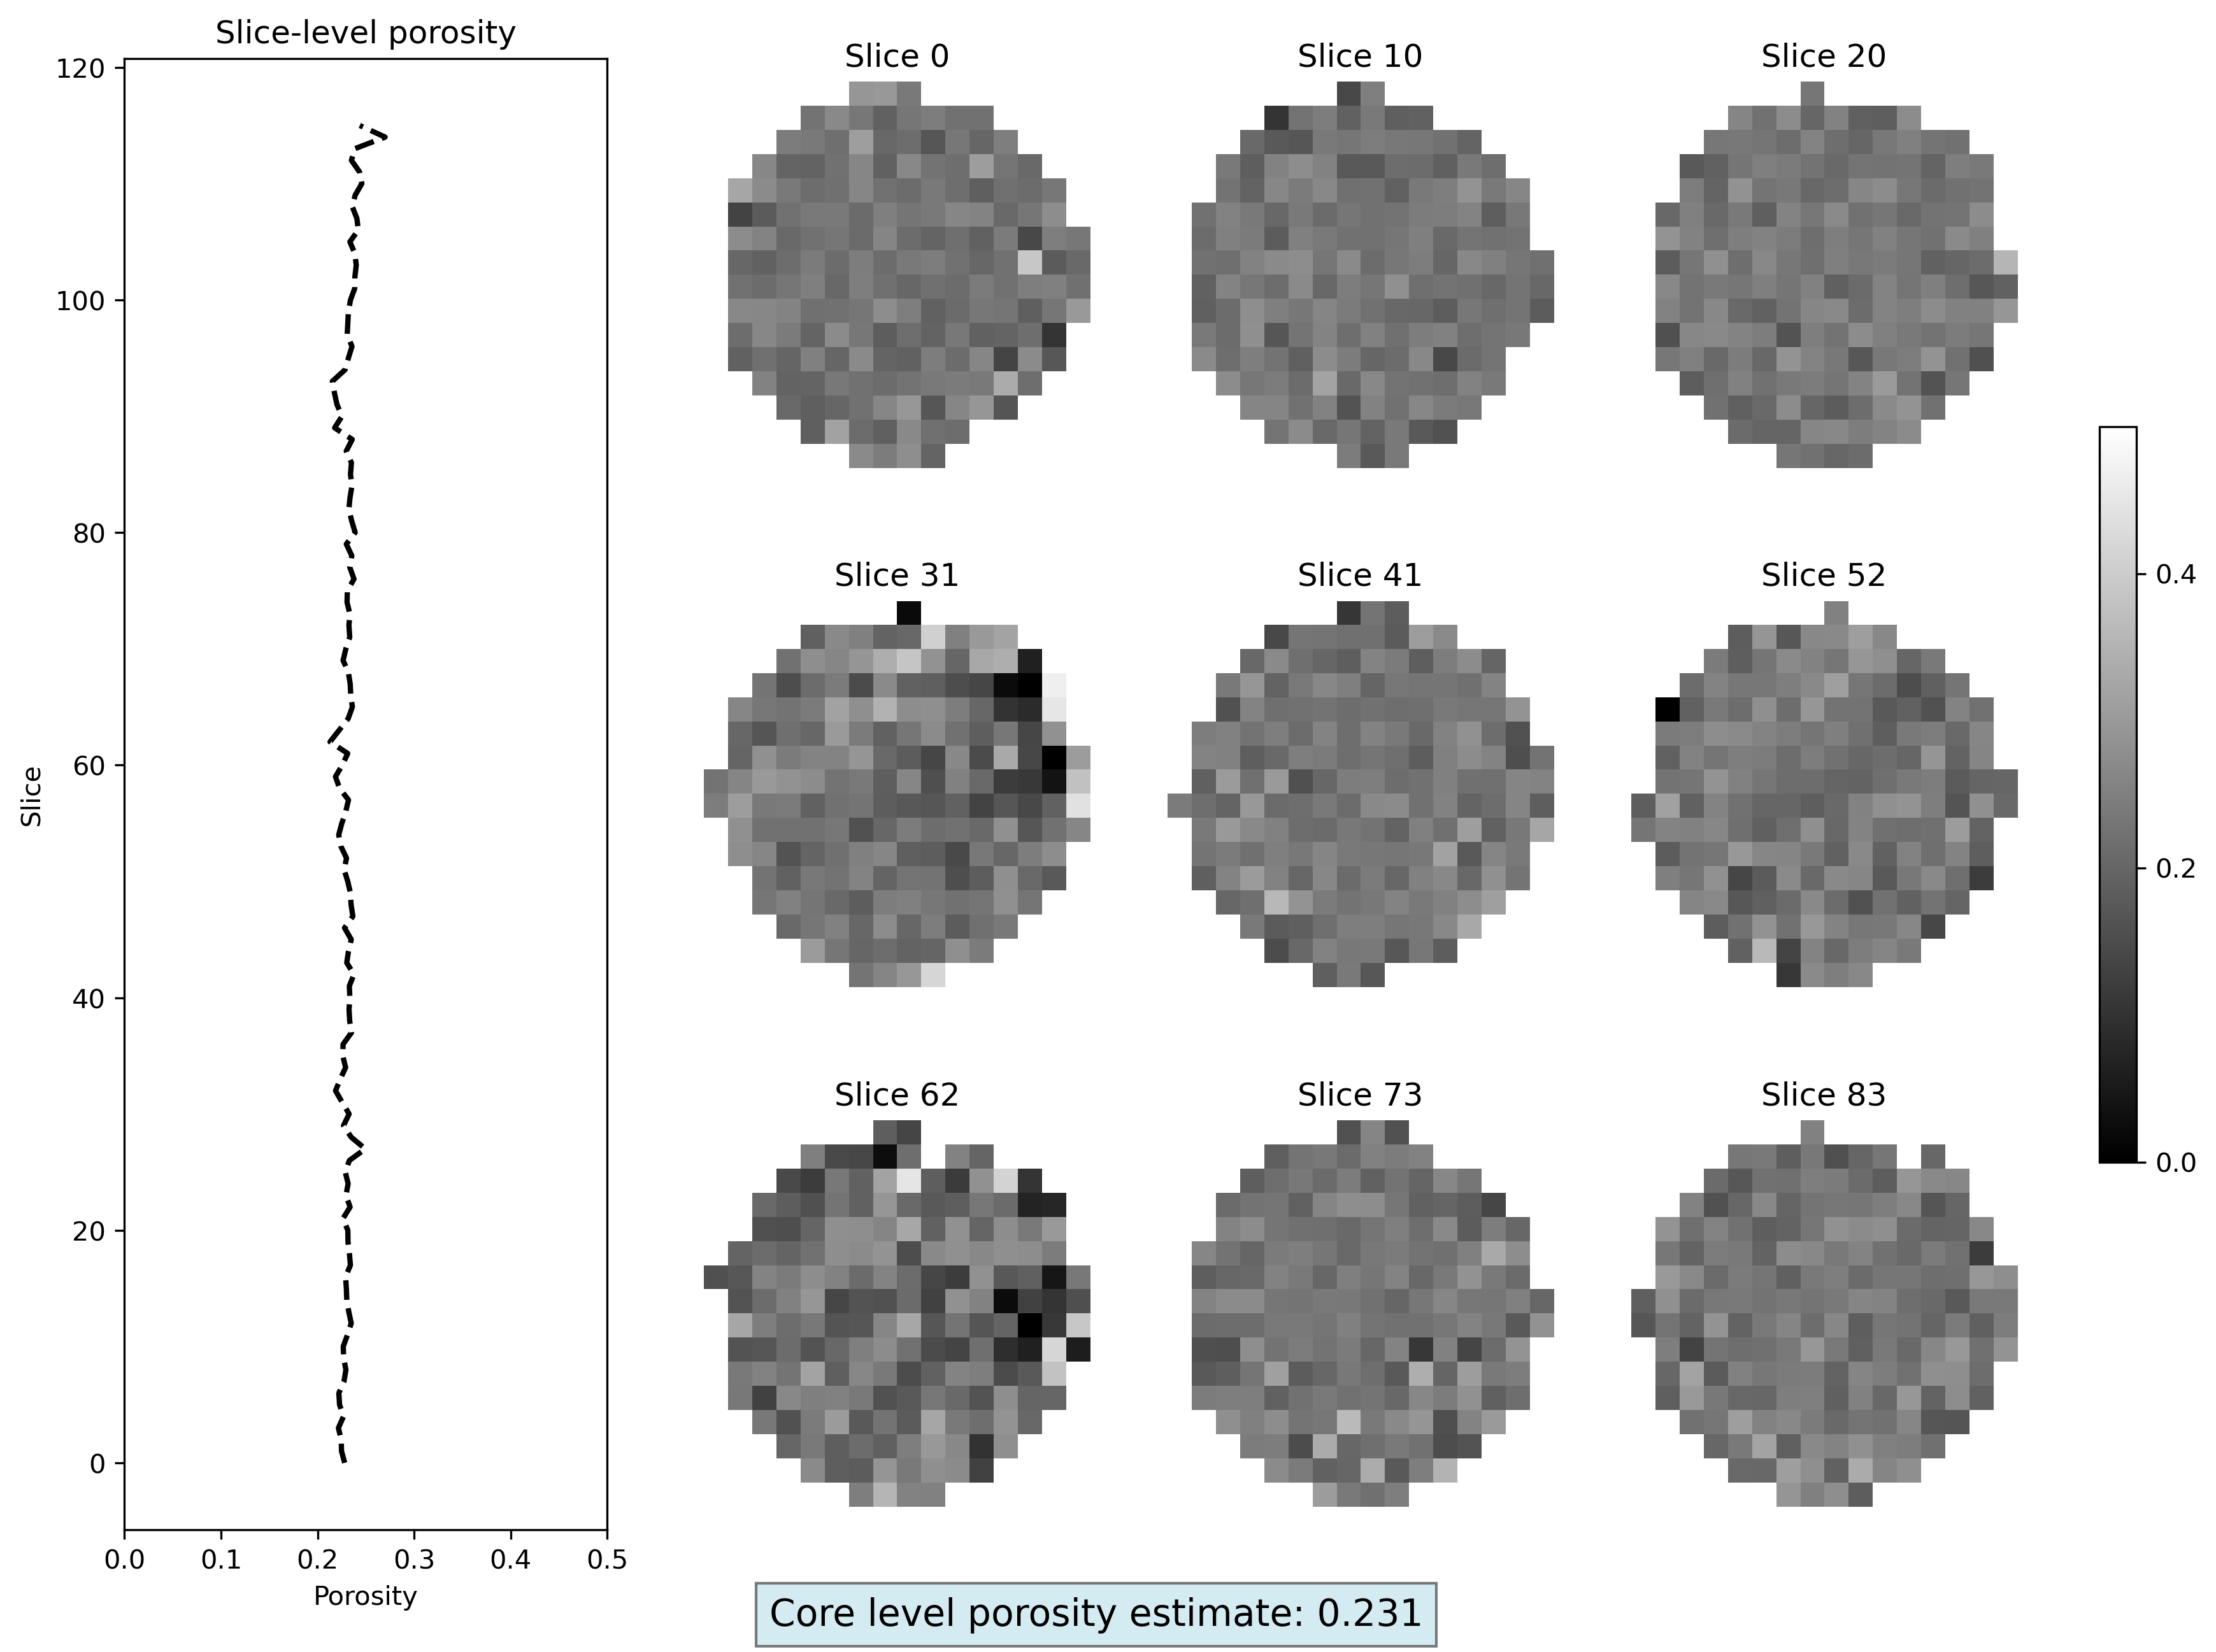

In [12]:
# Dashboard porosity
cp.dashboard_porosity(core_por,slice_por,voxel_por)

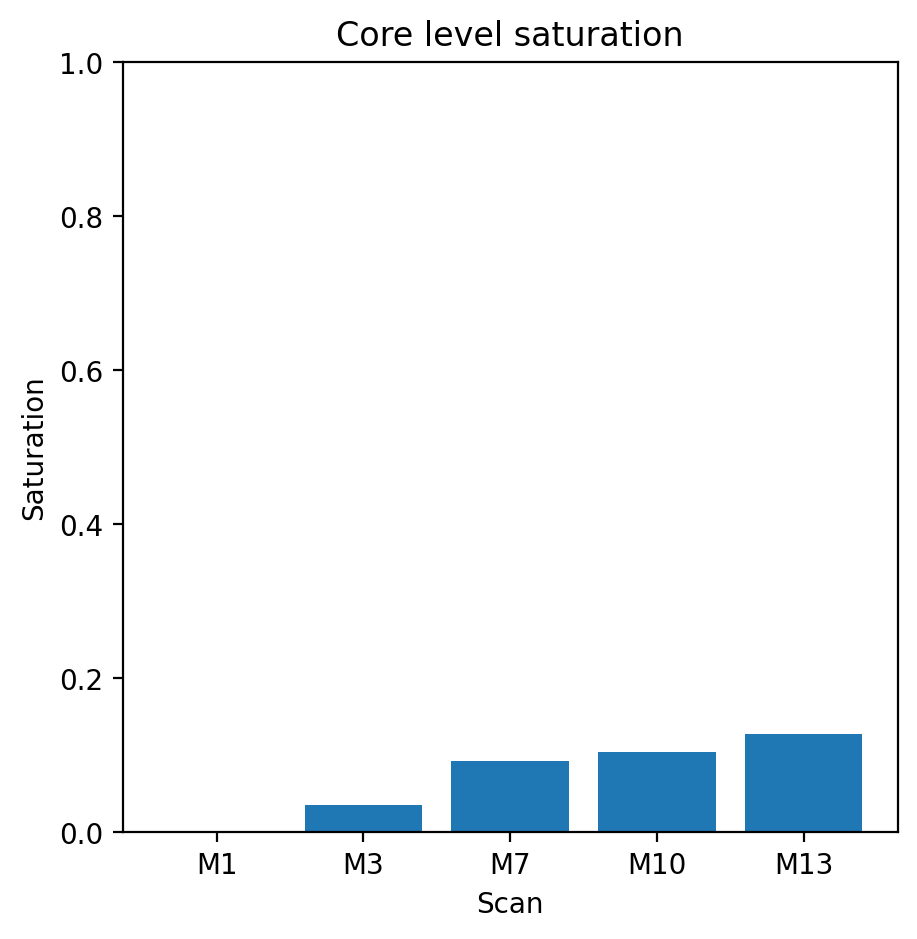

['M1', 'M3', 'M7', 'M10', 'M13']


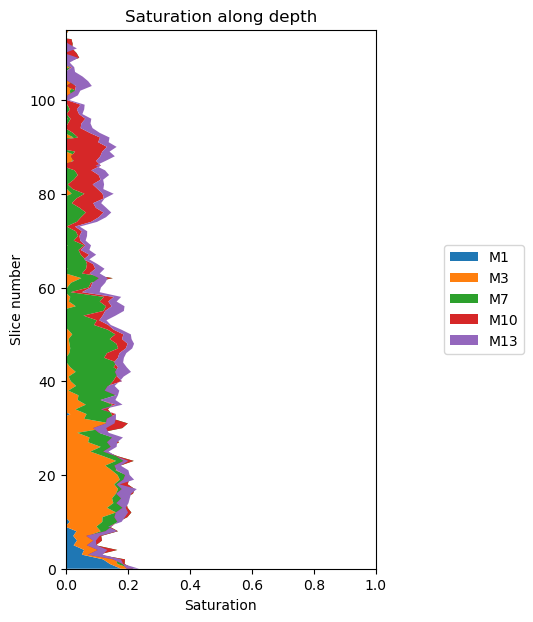

In [13]:
# Estimate saturation
wet = fdict['B'] ; co2 = fdict['C'] ; twophase = {key: fdict[key] for key in ['M1','M3','M7','M10','M13']}

core_sat = cp.core_level_saturation(wet,co2,twophase)
slice_sat = cp.compute_saturation_along_depth(wet,co2,twophase)
voxel_sat = cp.voxel_level_saturation(wet,co2,twophase)

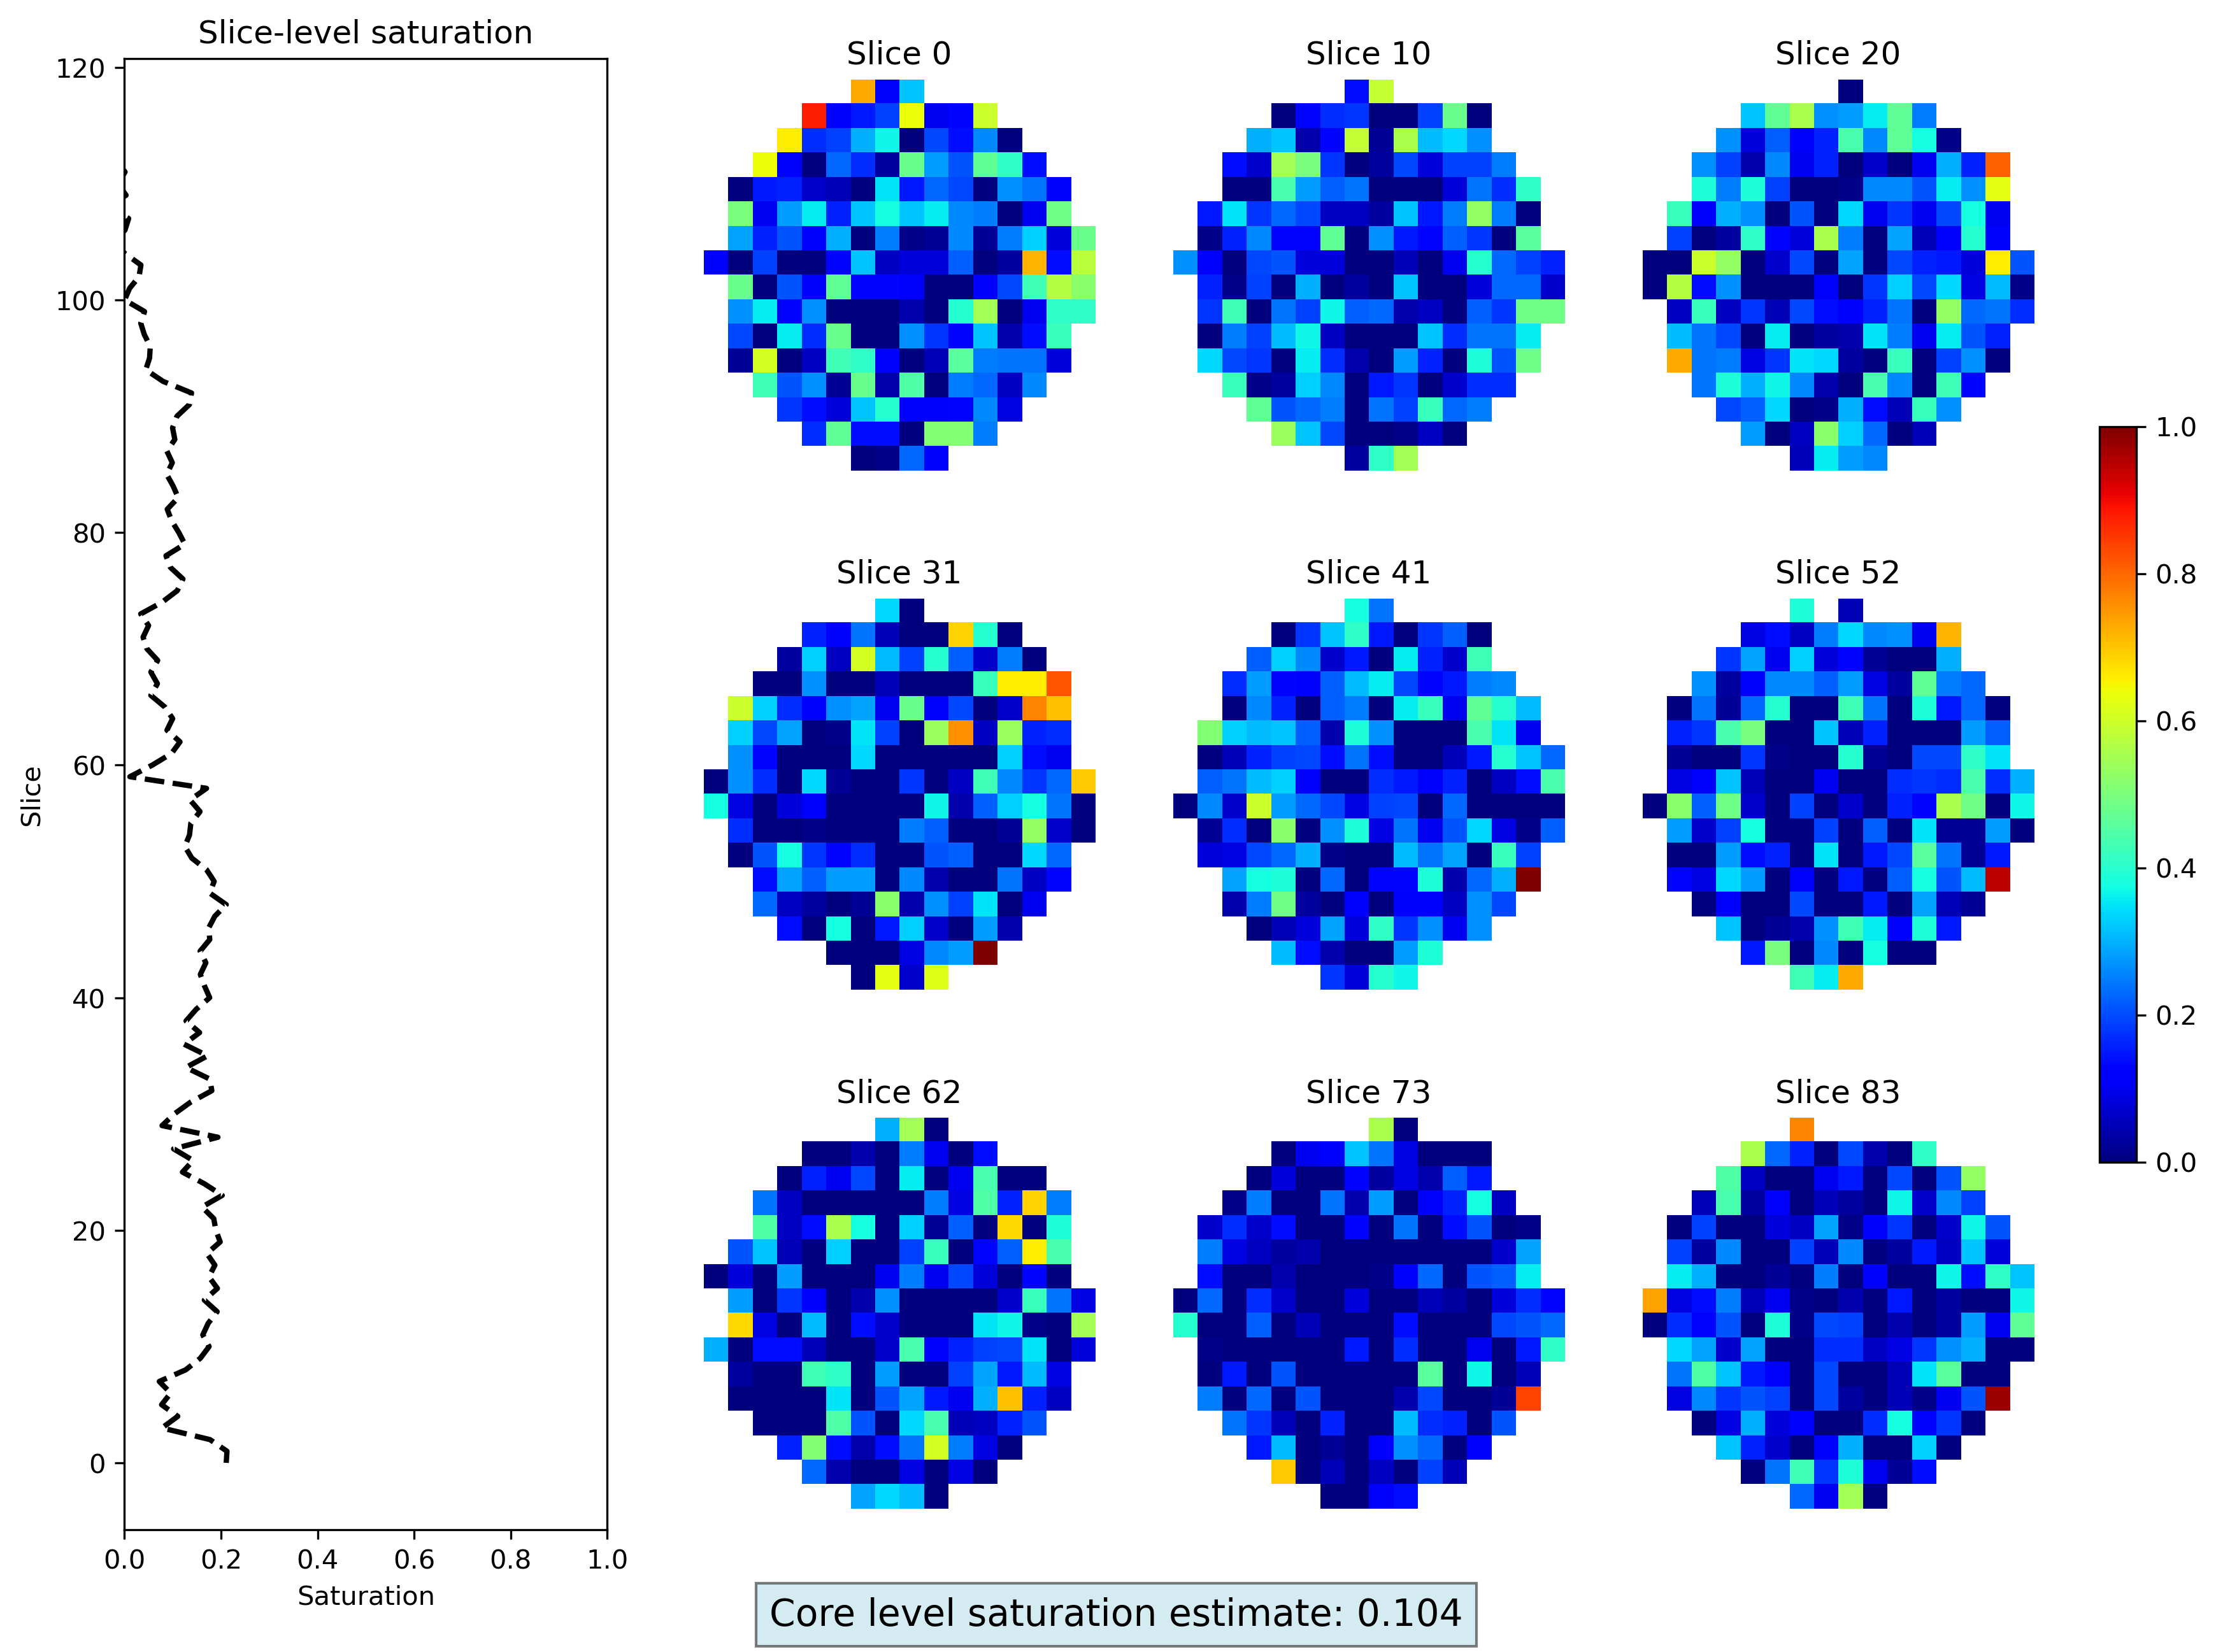

In [15]:
# Dashboard saturation
cp.dashboard_saturation(wet,co2,twophase['M10'])